<a href="https://colab.research.google.com/github/BarnabasObuya/portfolio/blob/main/2_Apartment_prices_in_Mexico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries here
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

In [ ]:
data=pd.read_csv('/content/mexico-city-real-estate-1.csv')
data.head()

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",5500000.0,MXN,5450245.50,289775.66,NaN,54.0,NaN,101851.851900,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/o3zb...
1,sell,house,|Iztapalapa|Distrito Federal|México|,"19.31033,-99.068557",1512000.0,MXN,1498321.97,79661.96,NaN,80.0,NaN,18900.000000,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/q7t0_venta_...
2,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.670000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
3,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",6410000.0,MXN,6352013.39,337720.36,NaN,135.0,NaN,47481.481480,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/opeq...
4,sell,apartment,|Benito Juárez|Quintana Roo|México|,"21.1902642,-86.8198375",875000.0,USD,16457437.50,875000.00,0.0,263.0,NaN,3326.996198,NaN,NaN,NaN,http://cancun.properati.com.mx/hg4t_venta_depa...


Prepare Data

Import

Task 2.5.1: Write a wrangle function that takes the name of a CSV file as input and returns a DataFrame.

The function should do the following steps:

Subset the data in the CSV file and return only apartments in Mexico City ("Distrito Federal") that cost less than $100,000.

Remove outliers by trimming the bottom and top 10% of properties in terms of "surface_covered_in_m2".

Create separate "lat" and "lon" columns.

Mexico City is divided into 15 boroughs. Create a "borough" feature from the "place_with_parent_names" column.

Drop columns that are more than 50% null values.

Drop columns containing low- or high-cardinality categorical values.

Drop any columns that would constitute leakage for the target "price_aprox_usd".
Drop any columns that would create issues of multicollinearity.

In [ ]:
# Build your `wrangle` function
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than $100,000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name for the borough
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)

    #drop features with 50% null counts
    df.drop(columns=['floor' , 'expenses'], inplace=True)

    #drop low and high cardinality categorical variables
    df.drop(columns=['operation', 'property_type', 'currency','properati_url' ], inplace=True)

    #I will drop some features that are not usefull for our model
    df.drop(columns=[ 'price',
     'price_aprox_local_currency',
     'price_per_m2',
     'price_usd_per_m2'
    ], inplace=True)

    df.drop(columns=['surface_total_in_m2', 'rooms'], inplace=True)


    return df

In [ ]:
# Use this cell to test your wrangle function and explore the data
df = wrangle('/content/mexico-city-real-estate-1.csv')
print("df shape:", df.shape)
df.head()

df shape: (1101, 5)


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [ ]:
df['borough'].unique()

array(['Benito Juárez', 'Iztacalco', 'Azcapotzalco', 'Coyoacán',
       'Álvaro Obregón', 'Iztapalapa', 'Cuauhtémoc', 'Tláhuac',
       'Miguel Hidalgo', 'Venustiano Carranza', 'Tlalpan',
       'Gustavo A. Madero', 'Xochimilco', 'La Magdalena Contreras'],
      dtype=object)

In [ ]:
# Use glob to create the list files. It should contain the filenames of all the Mexico City real estate CSVs in the ./data directory, except for mexico-city-test-features.csv.

files = glob('/content/mexico-city-real-estate-*.csv') #we use the asteric sign * to reference to all the files with almost the same name
files

['/content/mexico-city-real-estate-5.csv',
 '/content/mexico-city-real-estate-4.csv',
 '/content/mexico-city-real-estate-3.csv',
 '/content/mexico-city-real-estate-2.csv',
 '/content/mexico-city-real-estate-1.csv']

In [ ]:
# Combine your wrangle function, a list comprehension, and pd.concat to create a DataFrame df. It should contain all the properties from the five CSVs in files.

#combining all the CSV files in the wrangle function
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,82737.39,75.0,19.362690,-99.150565,Benito Juárez
1,72197.60,62.0,19.291345,-99.124312,Tlalpan
2,44277.72,85.0,19.354987,-99.061709,Iztapalapa
3,60589.45,52.0,19.469681,-99.086136,Gustavo A. Madero
4,47429.08,53.0,19.443592,-99.121407,Venustiano Carranza


In [ ]:
df.shape

(5473, 5)

## Explore

Text(0.5, 1.0, 'Distribution of Apartment Prices')

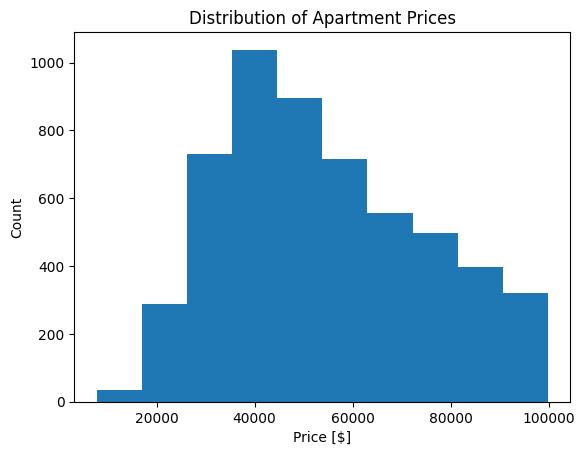

In [ ]:
#Task 2.5.4: Create a histogram showing the distribution of apartment prices ("price_aprox_usd") in df. Be sure to label the x-axis "Price [$]", the y-axis "Count", and give it the title "Distribution of Apartment Prices". Use Matplotlib (plt).

#What does the distribution of price look like? Is the data normal, a little skewed, or very skewed?

# Build histogram
plt.hist(df["price_aprox_usd"])
#label x axis
plt.xlabel("Price [$]")
#labely axis
plt.ylabel("Count")
#add title
plt.title("Distribution of Apartment Prices")

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

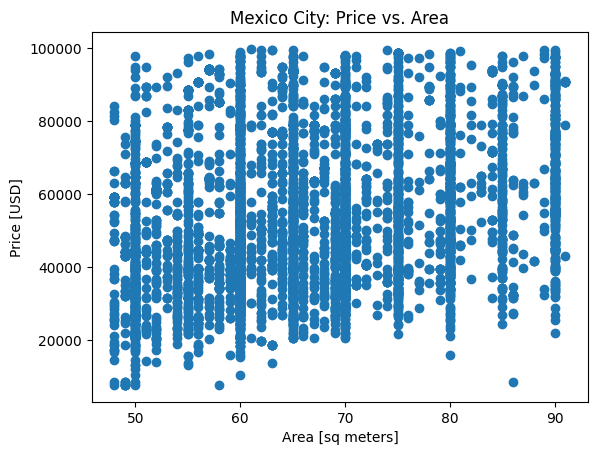

In [ ]:
# Create a scatter plot that shows apartment price ("price_aprox_usd") as a function of apartment size ("surface_covered_in_m2"). Be sure to label your x-axis "Area [sq meters]" and y-axis "Price [USD]". Your plot should have the title "Mexico City: Price vs. Area". Use Matplotlib (plt).

# Build scatter plot
plt.scatter(df['surface_covered_in_m2'], df['price_aprox_usd'])
# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel('Price [USD]')
# Add title
plt.title('Mexico City: Price vs. Area')

In [ ]:
#Create a Mapbox scatter plot that shows the location of the apartments in your dataset and represent their price using color.

# What areas of the city seem to have higher real estate prices?

# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat='lat',
    lon='lon',
    width=600,  # Width of map
    height=600,  # Height of map
    color='price_aprox_usd',
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

## Split

In [ ]:
# Create your feature matrix X_train and target vector y_train. Your target is "price_aprox_usd". Your features should be all the columns that remain in the DataFrame you cleaned above.
# Split data into feature matrix `X_train` and target vector `y_train`.
target='price_aprox_usd'
features=df.drop(columns=[target])
X_train = features
y_train = df[target]

## Build Model Baseline

In [ ]:
# Calculate the baseline mean absolute error for your model.

y_mean = y_train.mean()
y_pred_baseline = [y_mean]* len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


## Iterate

In [ ]:
#Create a pipeline named model that contains all the transformers necessary for this dataset and one of the predictors you've used during this project. Then fit your model to the training data.

# Build Model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge() # we use Ridge to do away with overfitting
)
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Communicate Results

In [ ]:
# Use your model to generate a Series of predictions for X_test. When you submit your predictions to the grader, it will calculate the mean absolute error for your model.
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/mexico-city-test-features.csv'

In [ ]:
# Create a Series named feat_imp. The index should contain the names of all the features your model considers when making predictions; the values should be the coefficient values associated with each feature. The Series should be sorted ascending by absolute value.

coefficients = model.named_steps['ridge'].coef_
features = model.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients, index=features)
feat_imp

<ipython-input-29-c72f55f56991>:4: FutureWarning:

`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.



,0
surface_covered_in_m2,291.654156
lat,478.901375
lon,-2492.221814
borough_Benito Juárez,13778.188880
borough_Tlalpan,10319.429804
borough_Iztapalapa,-13349.017448
borough_Gustavo A. Madero,-6637.429757
borough_Venustiano Carranza,-5609.918629
borough_Iztacalco,405.403127
borough_Coyoacán,3737.561001


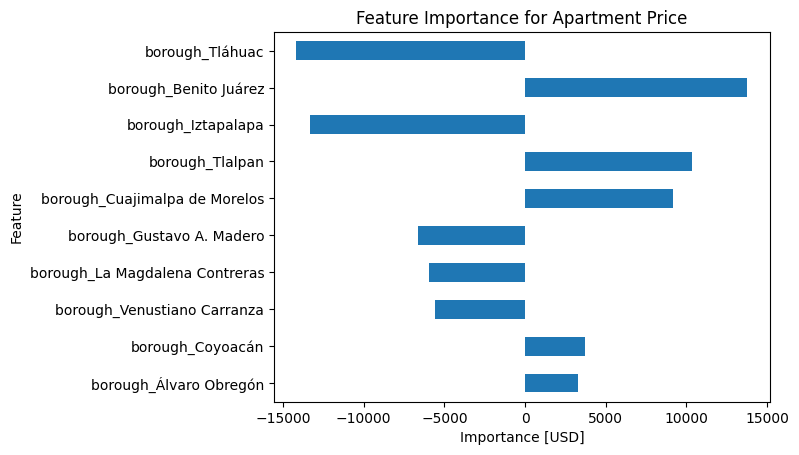

In [ ]:
#Create a horizontal bar chart that shows the 10 most influential coefficients for your model. Be sure to label your x- and y-axis "Importance [USD]" and "Feature", respectively, and give your chart the title "Feature Importances for Apartment Price". Use pandas.

# Build bar chart
feat_imp.sort_values(key=abs).tail(10).plot(kind='barh')
plt.xlabel('Importance [USD]')
plt.ylabel('Feature')
plt.title('Feature Importance for Apartment Price');
# Build bar chart
feat_imp.sort_values(key=abs).tail(10).plot(kind='barh')
plt.xlabel('Importance [USD]')
plt.ylabel('Feature')
plt.title('Feature Importance for Apartment Price');

## Make prediction

In [ ]:
#Make prediction
def make_prediction(area, latitude, longitude, borough):
    data = {
        'surface_covered_in_m2': area,
        'lat': latitude,
        'lon': longitude,
        'borough': borough
    }
    df=pd.DataFrame(data, index=[0])
    prediction = model.predict(df)
    return f"Predicted apartment price: ${prediction}"

In [ ]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    latitude=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    longitude=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    borough=Dropdown(options=sorted(X_train["borough"].unique())),
);

interactive(children=(IntSlider(value=66, description='area', max=91, min=48), FloatSlider(value=19.4531123034…

In [ ]:
# df.to_csv('data/mexico_data.csv', index=False)  save the data to a directory